# Setup
## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import rotate
from skimage.util import montage
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.model_selection import train_test_split
import pickle

!pip install segmentation_models_3D
import segmentation_models_3D as sm
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, Cropping3D
from keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam

Segmentation Models: using `keras` framework.


# Directory

In [ ]:
#environment
root_dir = 'drive/MyDrive/School/Summer 2024/Practicum/Custom Models/Segmentation'
image_dir = os.path.join(root_dir, 'Images')
train_folder_path = os.path.join(root_dir, 'Data/Train/MICCAI_BraTS2020_TrainingData')
test_folder_path = os.path.join(root_dir, 'Data/Test/MICCAI_BraTS2020_ValidationData')

#example folders for testing
ex_folder = os.path.join(train_folder_path, 'BraTS20_Training_001')
ex_folder_2 = os.path.join(train_folder_path, 'BraTS20_Training_002')
ex_folder_3 = os.path.join(train_folder_path, 'BraTS20_Training_003')
ex_folder_4 = os.path.join(train_folder_path, 'BraTS20_Training_004')

#example paths for testing
t1_path = os.path.join(ex_folder, 'BraTS20_Training_001_t1.nii')
flair_path = os.path.join(ex_folder, 'BraTS20_Training_001_flair.nii')
t1_ce_path = os.path.join(ex_folder, 'BraTS20_Training_001_t1ce.nii')
t2_path = os.path.join(ex_folder, 'BraTS20_Training_001_t2.nii')
seg_path = os.path.join(ex_folder, 'BraTS20_Training_001_seg.nii')

#examples images
t1_img = nib.load(t1_path).get_fdata()
flair_img = nib.load(flair_path).get_fdata()
t2_img = nib.load(t2_path).get_fdata()
t1ce_img = nib.load(t1_ce_path).get_fdata()
seg_img = nib.load(seg_path).get_fdata()

# EDA

## Single slice visualization of all channels

In [ ]:
def print_slice_from_folder(folder_path: str, index: int=50, save=False):
    file_types = ['t1', 't1ce', 't2', 'flair', 'seg']
    fig, axes = plt.subplots(1, len(file_types), figsize=(20, 5))

    folder_name = os.path.basename(folder_path)
    prefix = folder_name.split('_', 2)[-1]

    for i, file_type in enumerate(file_types):
        file_path = os.path.join(folder_path, f'{folder_name}_{file_type}.nii')
        img = nib.load(file_path)
        img_data = img.get_fdata()

        axes[i].imshow(img_data[:, :, index], cmap='gray')
        axes[i].set_title(file_type)
        axes[i].axis('off')

    if save:
      save_name = f'{folder_name}_slice_{index}.png'
      save_path = os.path.join(image_dir, save_name)
      plt.savefig(save_path)
      print('figure saved.')

## print many slices

(-0.5, 2639.5, 1704.5, -0.5)

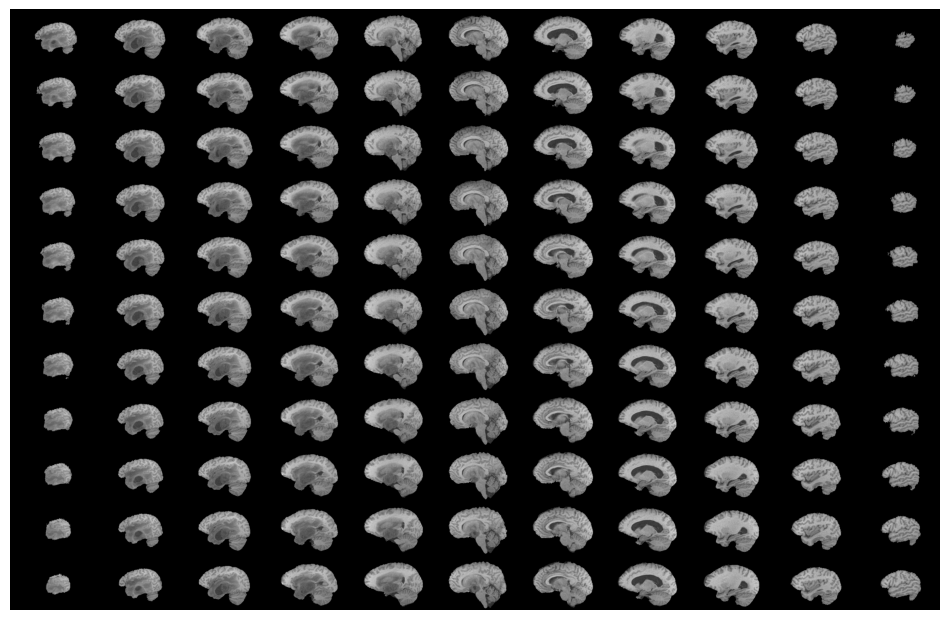

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12,12))
ax.imshow(rotate(montage(t1_img[60:-59,:,:]), 90, resize=True), cmap='gray')
ax.axis("off")

## Create video of brain slices
Any axis possible

In [ ]:
def update(slice_index, axis, img_data, ax):
    ax.clear()
    if axis == 0:
        ax.imshow(rotate(img_data[slice_index, :, :], 90), cmap='gray')
    elif axis == 1: #didn't test
        ax.imshow(img_data[:, slice_index, :], cmap='gray')
    else: #didn't test
        ax.imshow(img_data[:, :, slice_index], cmap='gray')

    ax.set_title(f'Slice {slice_index}')
    ax.axis("off")

def animate(img_data, axis=2, save=False, filename='brain_video.mp4'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    def update_wrapper(slice_index):
        return update(slice_index, axis, img_data, ax)

    ani = animation.FuncAnimation(fig, update_wrapper, frames=range(img_data.shape[axis]), interval=80)
    display(HTML(ani.to_jshtml())) #for the notebook
    if save:
      save_path = os.path.join(image_dir, filename)
      ani.save(save_path, writer='ffmpeg')
      print('video saved')

    return ani

#animate(ex_img_data[50:180,:,:], axis=0, save=True)


## Data Generator


In [ ]:
class MRIDataGenerator(Sequence):
    def __init__(self, data_paths, batch_size=4, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.data_paths = data_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def _scale_img(self, img_path):
        scalar = MinMaxScaler()
        img = nib.load(img_path).get_fdata()
        cropped_img = self._crop(img)
        img_reshaped = cropped_img.reshape(-1, 1)  # Must be 2D to scale
        img_scaled = scalar.fit_transform(img_reshaped)
        img_scaled = img_scaled.reshape(cropped_img.shape)  #Back to cropped shape

        return img_scaled.astype(np.float32)

    def _crop(self, img):
        return img[56:-56, 56:-56, 13:-14]

    def _recode_labels(self, seg_path):
        seg = nib.load(seg_path).get_fdata()
        seg = self._crop(seg)
        seg[seg == 4] = 3
        seg_categorical = to_categorical(seg, num_classes=4)
        return seg_categorical.astype(np.float32)

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.data_paths) / self.batch_size))

    # Generate one batch of data
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.data_paths[i] for i in indices]

        t1ce_paths_batch = [path[0] for path in batch_paths]
        t2_paths_batch = [path[1] for path in batch_paths]
        flair_paths_batch = [path[2] for path in batch_paths]
        seg_paths_batch = [path[3] for path in batch_paths]

        X, y = self.__data_generation(t1ce_paths_batch, t2_paths_batch, flair_paths_batch, seg_paths_batch)
        return X, y

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.data_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, t1ce_paths_batch, t2_paths_batch, flair_paths_batch, seg_paths_batch):
        # Initialize
        X = np.empty((self.batch_size, 128, 128, 128, 3), dtype=np.float32)
        y = np.empty((self.batch_size, 128, 128, 128, 4), dtype=np.float32)

        # Generate data
        for i in range(len(t1ce_paths_batch)):
            t1ce_img = self._scale_img(t1ce_paths_batch[i])
            t2_img = self._scale_img(t2_paths_batch[i])
            flair_img = self._scale_img(flair_paths_batch[i])
            seg_img = self._recode_labels(seg_paths_batch[i])

            # Stack images
            img_stack = np.stack([t1ce_img, t2_img, flair_img], axis=-1)

            X[i,] = img_stack
            y[i,] = seg_img

        return X, y


def get_all_paths(root_folder):
        t1ce_paths = []
        t2_paths = []
        flair_paths = []
        seg_paths = []

        for folder_name in os.listdir(root_folder):
            if '_063' in folder_name and 'Training' in folder_name:
                continue
            folder_path = os.path.join(root_folder, folder_name)
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    if '_t1ce.nii' in file_name:
                        t1ce_paths.append(file_path)
                    elif '_t2.nii' in file_name:
                        t2_paths.append(file_path)
                    elif '_flair.nii' in file_name:
                        flair_paths.append(file_path)
                    elif '_seg.nii' in file_name:
                        seg_paths.append(file_path)

        return t1ce_paths, t2_paths, flair_paths, seg_paths

# have to split training folder into training and test because validation has no masks
def split_data(train_folder_path, test_size=0.2, random_state=50):
    t1ce_paths, t2_paths, flair_paths, seg_paths = get_all_paths(train_folder_path)

    data_paths = list(zip(t1ce_paths, t2_paths, flair_paths, seg_paths))
    train_paths, val_paths = train_test_split(data_paths, test_size=test_size, random_state=random_state)

    return train_paths, val_paths


## Testing above functions


In [ ]:
train_paths, test_paths = split_data(train_folder_path)
train_gen = MRIDataGenerator(train_paths, batch_size=2, shuffle=True)
test_gen = MRIDataGenerator(test_paths, batch_size=2, shuffle=False)

X, y = train_gen[0]
#X, y = test_gen[0]

In [ ]:

print(f"X shape: {X.shape}")  # Expected shape: (batch_size, 128, 128, 128, 3)
print(f"y shape: {y.shape}")  # Expected shape: (batch_size, 128, 128, 128, 4)

def plot_sample(X, y, slice_index):
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    axes[0].imshow(X[:, :, slice_index, 0], cmap='gray')
    axes[0].set_title('T1ce')
    axes[1].imshow(X[:, :, slice_index, 1], cmap='gray')
    axes[1].set_title('T2')
    axes[2].imshow(X[:, :, slice_index, 2], cmap='gray')
    axes[2].set_title('Flair')
    axes[3].imshow(np.argmax(y[:, :, slice_index, :], axis=-1), cmap='gray')
    axes[3].set_title('Segmentation')
    plt.show()

plot_sample(X[1], y[1], slice_index=70)

NameError: name 'X' is not defined

In [ ]:
#exploring whether to include whole brain scans
def plot_all_slices(path):
    img = nib.load(path).get_fdata()
    fig, ax = plt.subplots(1, 1, figsize = (12,12))
    ax.imshow(rotate(montage(img[56:-56, 56:-56, 13:-14]), 90, resize=True), cmap='gray')
    ax.axis("off")

# for path in train_paths[:5]:
#     plot_all_slices(path[3])

# Model

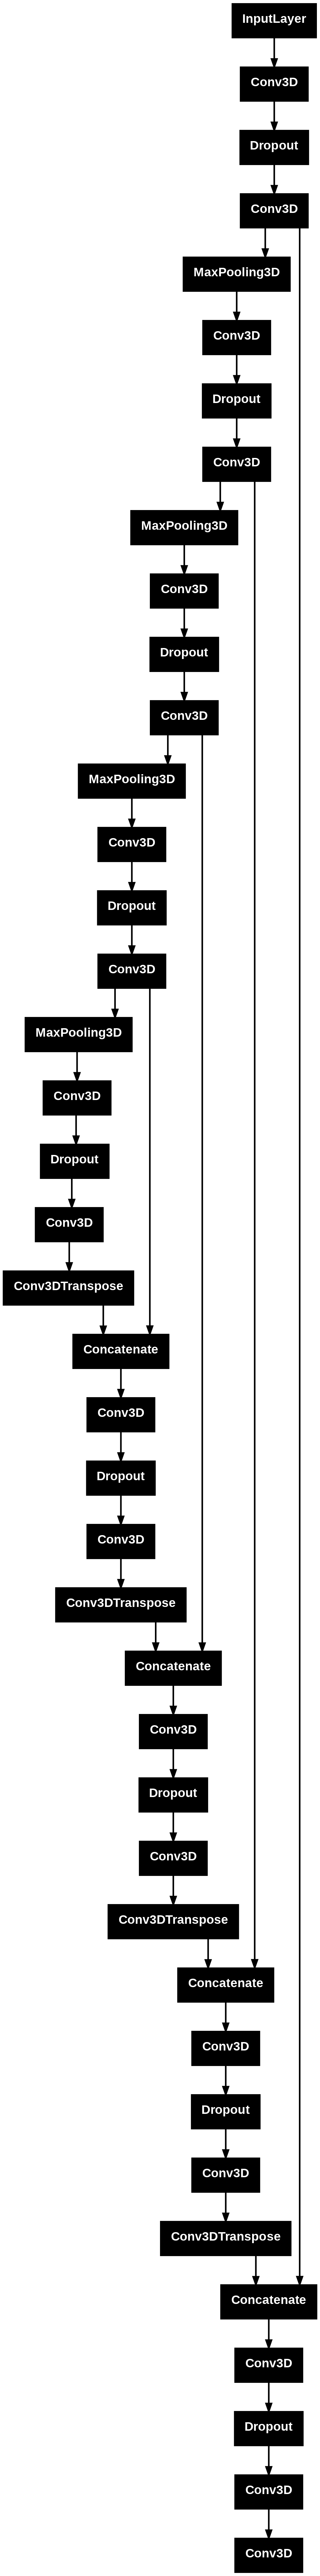

In [ ]:
#This model is from this github repo: https://tinyurl.com/2zrolur5 (author: Sreenivas Bhattiprolu)

from tensorflow.keras.utils import plot_model
def unet_3D(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes, kernel_initializer='he_uniform'):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_3D(128, 128, 128, 3, 4)
# print(model.input_shape)
# print(model.output_shape)
# model.summary()
plot_model(model,show_layer_names=False, to_file='unet.png')

In [ ]:
#custom loss function
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#Assessment metrics
import tensorflow.keras.backend as K
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

log_dir = os.path.join(root_dir, 'Logs')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

checkpoints = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, min_lr=1e-6),
    ModelCheckpoint(filepath=os.path.join(log_dir, 'custom_loss.keras'), monitor='val_loss', save_best_only=True, verbose=1)
]

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=total_loss,
              metrics=[sm.metrics.IOUScore(threshold=0.5), 'accuracy', f1_score, precision, recall])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 128,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 128,  │          1,312 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128,  │              0 │ conv3d[0][0]           │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 128,  │          6,928 │ dropout[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 64, 16) │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64, 32) │              0 │ conv3d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 64, 64, 64, 32) │         27,680 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 32, 32, 32, 32) │              0 │ conv3d_3[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32, 64) │              0 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 32, 32, 32, 64) │        110,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_2           │ (None, 16, 16, 16, 64) │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 16,     │              0 │ conv3d_6[0][0]         │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
train = False
#batch size of 8 reaches 38.1 GB RAM. Need A100 for that.
if train:
  train_paths, test_paths = split_data(train_folder_path)
  train_gen = MRIDataGenerator(train_paths, batch_size=8, shuffle=True)
  test_gen = MRIDataGenerator(test_paths, batch_size=8, shuffle=False)

  history = model.fit(train_gen,
                      validation_data=test_gen,
                      epochs=50,
                      verbose = 1,
                      callbacks=checkpoints)

  history_path = os.path.join(root_dir, 'temp.pkl')
  model_path = os.path.join(root_dir, 'temp.keras')
  with open(history_path, 'wb') as f:
      pickle.dump(history.history, f)
  model.save(model_path)
  print('model and history saved')

# Assessment

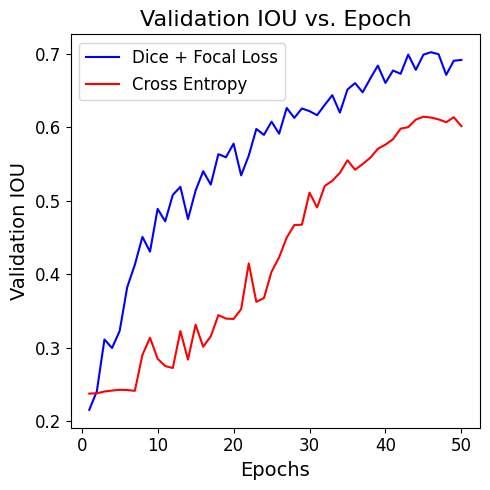

In [ ]:
# Load the history objects
custom_history_path = os.path.join(root_dir, 'custom_loss.pkl')
bce_history_path = os.path.join(root_dir, 'binary_cross_entropy.pkl')

with open(custom_history_path, 'rb') as f:
    custom_loss_history = pickle.load(f)

with open(bce_history_path, 'rb') as f:
    bce_history = pickle.load(f)

epochs= range(1, 51)
val_iou_custom = custom_loss_history['val_iou_score']
val_iou_bce = bce_history['val_iou_score']


plt.figure(figsize=(5, 5))
plt.plot(epochs, val_iou_custom, 'b-', label='Dice + Focal Loss')
plt.plot(epochs, val_iou_bce, 'r-', label='Cross Entropy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation IOU', fontsize=14)
plt.title('Validation IOU vs. Epoch', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [ ]:
from tensorflow.keras.models import load_model
custom_model_path = os.path.join(root_dir, 'custom_loss.keras')
bce_model_path = os.path.join(root_dir, 'binary_cross_entropy.keras')
custom_loss_model = load_model(custom_model_path, compile=False)
bce_model = load_model(bce_model_path, compile=False)

def display_images_and_masks(images, ground_truth_masks, predicted_masks):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 12))

    for i in range(num_images):
        axes[i, 0].imshow(images[i][:, :, 64, 0], cmap='gray')  # Showing the central slicem
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.argmax(ground_truth_masks[i][:, :, 64], axis=-1))
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(np.argmax(predicted_masks[i][:, :, 64], axis=-1))
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()



In [ ]:
test_gen = MRIDataGenerator(test_paths, batch_size=4, shuffle=False)
X_test, y_test = test_gen.__getitem__(0)
pred_masks = custom_loss_model.predict(X_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step


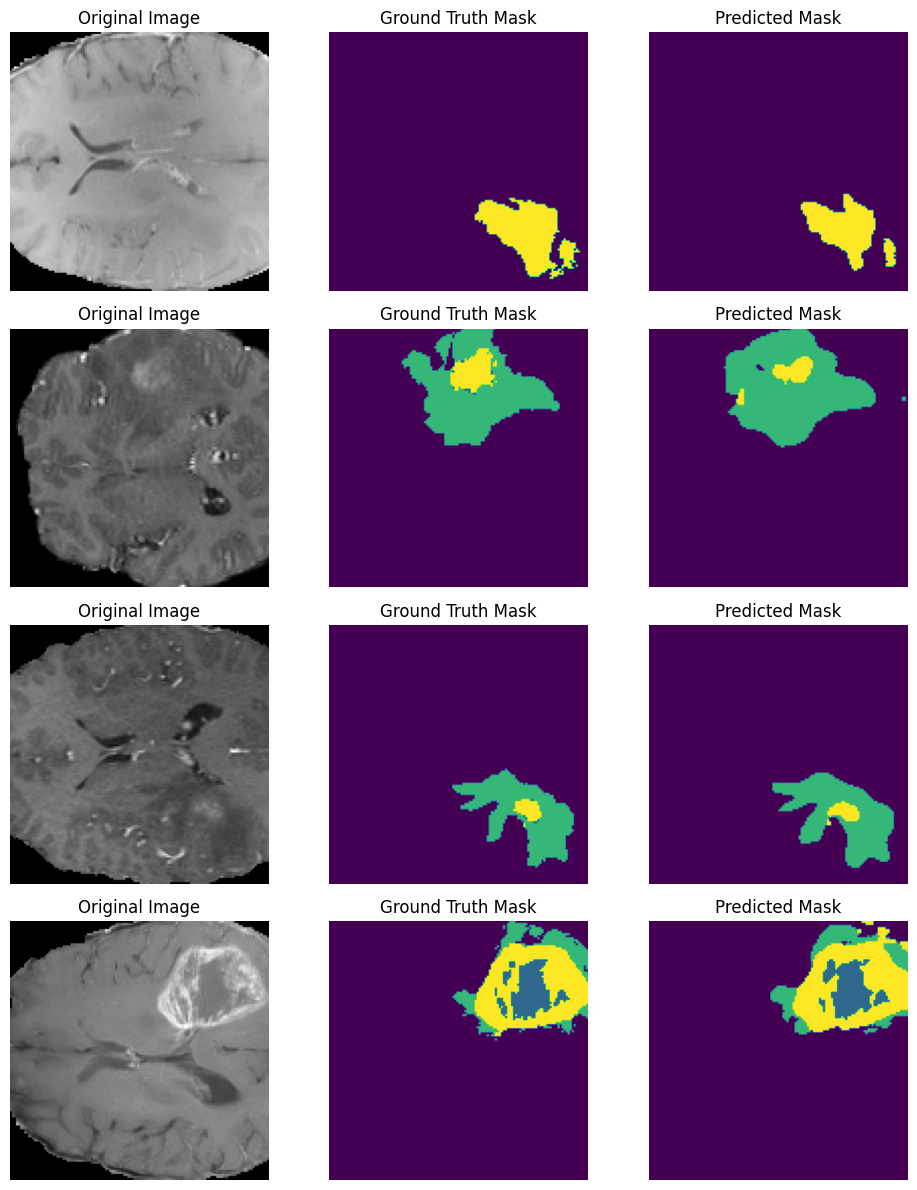

In [ ]:
display_images_and_masks(X_test, y_test, pred_masks)

In [ ]:

desired_keys = ["val_accuracy", "val_f1_score", "val_precision", "val_recall"] #all are .98

last_epoch_performance = {key: np.round(custom_loss_history[key][-1],2) for key in desired_keys if key in custom_loss_history}


{'val_accuracy': 0.98, 'val_f1_score': 0.98, 'val_precision': 0.98, 'val_recall': 0.98}


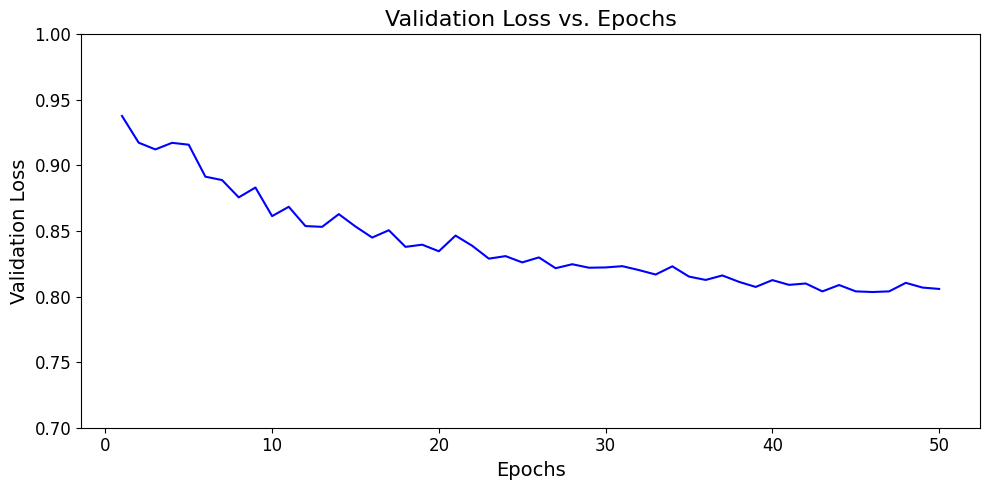

In [ ]:
val_loss = custom_loss_history['val_loss']
epochs = range(1, len(val_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.title('Validation Loss vs. Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.7, 1)
plt.tight_layout()
plt.show()


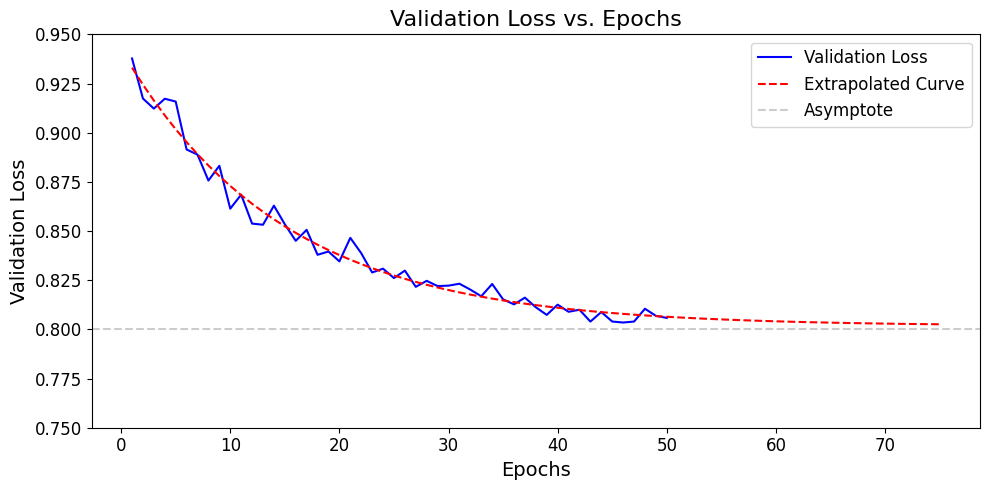

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define an exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Assuming custom_loss_history is already defined and contains 'val_loss'
val_loss = custom_loss_history['val_loss']
epochs = np.arange(1, len(val_loss) + 1)

# Fit the exponential function to the data
popt, pcov = curve_fit(exponential_func, epochs, val_loss, p0=(1, 0.1, 0.8))

# Generate extrapolated epochs
extrapolated_epochs = np.arange(1, len(val_loss) + 21)
extrapolated_val_loss = exponential_func(extrapolated_epochs, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.plot(extrapolated_epochs, extrapolated_val_loss, 'r--', label='Extrapolated Curve')
plt.axhline(y=0.8, color='gray', linestyle='--', alpha=0.4, label=f'Asymptote')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.title('Validation Loss vs. Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.75, 0.95)
plt.tight_layout()
